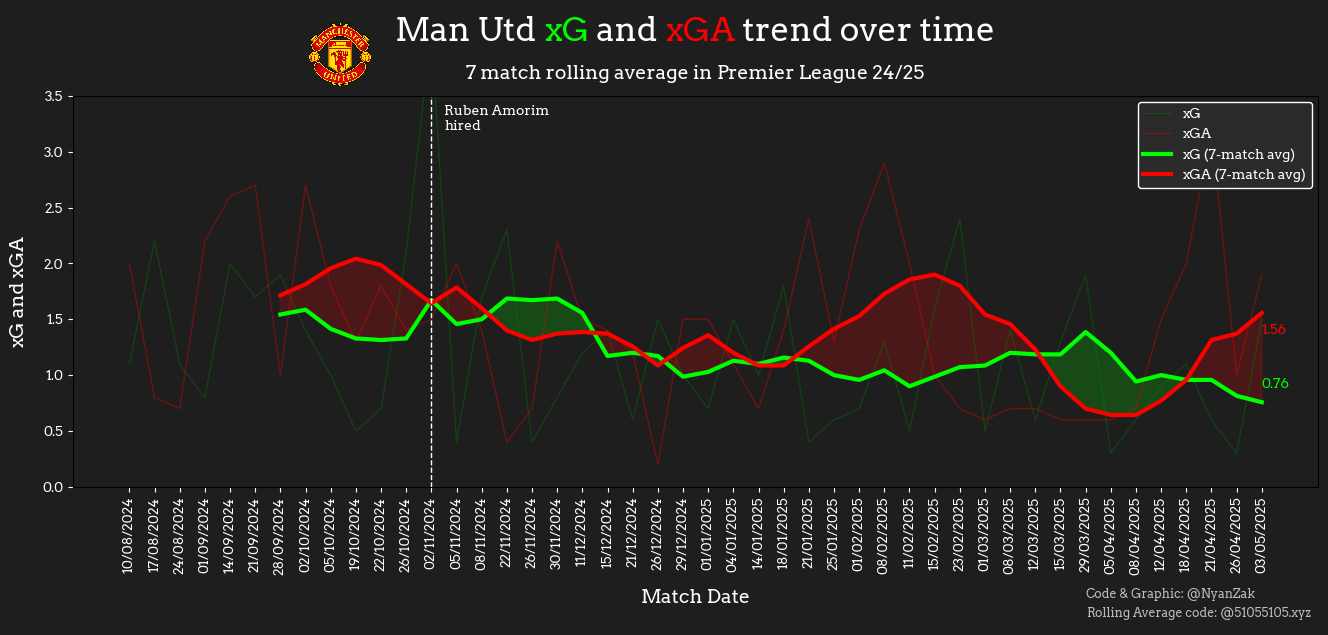

In [7]:
# === IMPORTS ===
from datetime import datetime
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
import requests
from io import StringIO
from highlight_text import fig_text
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pathlib import Path

# === CONFIGURATION ===
# Set team-specific and plot parameters here
teamname = "Man Utd" # Change this to any team name (used for paths and labels)
leaguename = "Premier League" # League name for titles and context
season = "2024-2025"# Season data is from
rollingavg = 7 # Rolling average window size

# === LOCAL PATHS ===
# Adjust these based on your directory structure
base_path = Path("D:/JN")  # Base directory
font_path = base_path / "Assets" / "Arvo-Regular.ttf"  # Path to font file (optional)
logo_path = base_path / "Team Logos" / f"{teamname}.png"  # Path to team logo image
output_path = base_path / "Outputs"  # Where to save the plot

# Load custom font
arvo_font = fm.FontProperties(fname=font_path)

# === FBREF MATCHLOG URLS ===
# Replace URLs with the appropriate FBref match logs for your team
url = "https://fbref.com/en/squads/19538871/2024-2025/matchlogs/c9/schedule/Manchester-United-Scores-and-Fixtures-Premier-League"

# === DATA RETRIEVAL AND PREPROCESSING ===
def fetch_xg_data(url):
    html = requests.get(url).text.replace('<!--','').replace('-->','')
    df = pd.read_html(StringIO(html))[0]
    df = df[['Date', 'xG', 'xGA']].dropna()
    df['Date'] = pd.to_datetime(df['Date'])
    return df

# Compute rolling averages
xGavg = df['xG'].rolling(rollingavg).mean() 
xGAavg = df['xGA'].rolling(rollingavg).mean()

# Match index ranges for x-axis
x = range(len(df))

# === PLOTTING SETUP ===
# Optional: Customize color scheme to match your preferred aesthetic
plt.style.use('default')
plt.rcParams.update({
    'figure.facecolor': '#1e1e1e',
    'axes.facecolor': '#1e1e1e',
    'savefig.facecolor': '#1e1e1e',
    'text.color': 'white',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'legend.edgecolor': 'white',
})

plt.figure(figsize=(14, 7))

# === RAW xG/xGA VALUES ===
plt.plot(x, df['xG'], color='green', alpha=0.35, linewidth=1, label='xG')
plt.plot(x, df['xGA'], color='red', alpha=0.35, linewidth=1, label='xGA')

# === ROLLING AVERAGES ===
plt.plot(x, xGavg, color='lime', linewidth=3, label=f'xG ({rollingavg}-match avg)')
plt.plot(x, xGAavg, color='red', linewidth=3, label=f'xGA ({rollingavg}-match avg)')

# === xG > xGA SHADED AREAS ===
plt.fill_between(x, xGavg, xGAavg, where=(xGavg >= xGAavg), color='#00FF00', interpolate=True, alpha=0.2)
plt.fill_between(x, xGavg, xGAavg, where=(xGavg < xGAavg), interpolate=True, color='#FF0000', alpha=0.2)

# === ANNOTATIONS ===
hire_date = pd.Timestamp('2024-11-01')
hire_index = df[df['Date'] >= hire_date].index.min()

if pd.notna(hire_index):
    hire_x = hire_index
    plt.axvline(x=hire_x, color='white', linestyle='--', linewidth=1)
    plt.text(hire_x + 0.5, 3.2, 'Ruben Amorim\nhired', color='white', fontsize=10,
             fontweight='bold', fontproperties=arvo_font)

# === LOGO OVERLAY ===
logo_img = mpimg.imread(logo_path)
imagebox = OffsetImage(logo_img, zoom=0.045) # Zoom factor for the logo size
ab = AnnotationBbox(imagebox, (0.22, 0.875), xycoords='figure fraction', box_alignment=(0, 1), frameon=False, pad=0.0)
plt.gcf().add_artist(ab)

# === TITLE AND SUBTITLE ===
fig_text(
    x=0.5, y=0.91,
    s=f"{teamname} <xG> and <xGA> trend over time",
    highlight_textprops=[
        {"color": "lime", "fontweight": "bold"},     # xG
        {"color": "red", "fontweight": "bold"}       # xGA
    ],
    ha="center", va="center",
    fontsize=24,
    fontproperties=arvo_font,
    color="white"
)

fig_text(
    x=0.5, y=0.85,
    s=f"<{rollingavg}> match rolling average in <{leaguename}> 24/25",
    ha="center", va="center",
    fontsize=14,
    fontproperties=arvo_font,
    color="white"
)

# === FINAL VALUE LABELS ===
plt.text(x[-1], xGavg.iloc[-1] + 0.1, f"{xGavg.iloc[-1]:.2f}", color='lime', fontproperties=arvo_font, va='bottom')
plt.text(x[-1], xGAavg.iloc[-1] - 0.1, f"{xGAavg.iloc[-1]:.2f}", color='red', fontproperties=arvo_font, va='top')

# === AXES AND TICKS ===
plt.xlabel("Match Date", fontsize=14, labelpad=10, fontproperties=arvo_font)
plt.ylabel("xG and xGA", fontsize=14, labelpad=10, fontproperties=arvo_font)
plt.ylim(0, 3.5)
plt.yticks([i * 0.5 for i in range(8)], fontproperties=arvo_font)

# Combine and format dates for x-axis ticks
plt.xticks(
    ticks=x,
    labels=df['Date'].dt.strftime('%d/%m/%Y'),
    rotation='vertical',
    ha='center',
    fontsize=6,
    fontproperties=arvo_font
)

# Grid off
plt.grid(False)

# Legend
plt.legend(
    loc='upper right',
    bbox_to_anchor=(1, 1.001),
    facecolor='#2a2a2a',
    framealpha=1,
    edgecolor='white',
    fontsize=12,
    prop=arvo_font
)

# === LEGEND & CREDITS ===
fig_text(
    x=0.94, y=0.115,
    s="Code & Graphic: @NyanZak \nRolling Average code: @51055105.xyz",
    ha="right", va="top",
    fontsize=9,
    color="white",
    fontproperties=arvo_font,
    alpha=0.7
)

# === SAVE AND SHOW ===
# Adjust layout to prevent overlapping and improve readability
plt.subplots_adjust(bottom=0.3, top=0.83)
plt.tight_layout(rect=[0, 0, 1, 0.95])
today = datetime.today().strftime('%Y-%m-%d')
filename = output_path / f"{teamname}_xGxGA_{season}_{today}.png"
filename.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()